In [1]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

# ______________________________________________________________________________
# Globals
nlayers = 25  # 13 (CSC) + 9 (RPC) + 3 (GEM)

#infile = '../test2/histos_tba.8.npz'
#infile = '../test2/histos_tba.9.npz'
infile = '../test2/histos_tba.10.npz'

#chsqfile = '../test2/chsq.10.npz'
chsqfile = 'chsq.npz'


[INFO] Using numpy 1.12.1
[INFO] Using sklearn 0.18.1


In [2]:
#### Load data ####

try:
    loaded = np.load(infile)
    the_parameters = loaded['parameters']
    the_variables = loaded['variables']
except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))

[INFO] Loaded the variables with shape (3162532, 104)
[INFO] Loaded the parameters with shape (3162532, 3)


In [3]:
class Encoder(object):

  def __init__(self, x, y, adjust_scale=0):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 4) + 4)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_mask  = self.x_copy[:, nlayers*3:nlayers*4].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*4:nlayers*5]  # ipt, ieta, iphi, iphi_corr
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      
      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0
      
      # Subtract median phi from hit phis
      #self.x_phi_median    = self.x_road[:, 2] * 32 - 16  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta, axis=1)
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Zones
      self.x_ieta  = self.x_road[:, 1].astype(np.int32)
      
      # Standard scales
      if adjust_scale == 0:  # do not adjust
        pass
      elif adjust_scale == 1:  # use mean and std
        self.x_mean  = np.nanmean(self.x_copy, axis=0)
        self.x_std   = np.nanstd(self.x_copy, axis=0)
        self.x_std   = self._handle_zero_in_scale(self.x_std)
        self.x_copy -= self.x_mean
        self.x_copy /= self.x_std
      elif adjust_scale == 2:  # use covariance
        with np.load(chsqfile) as loaded:
          self.x_cov = loaded['cov']
        nvariables_to_scale = self.x_cov.size
        self.x_copy[:, :nvariables_to_scale] *= self.x_cov
      
      # Remove outlier hits by checking hit thetas
      if adjust_scale == 0:  # do not adjust
        x_theta_tmp = np.abs(self.x_theta) > 10000.0
      else:
        x_theta_tmp = np.abs(self.x_theta) > 1.0
      self.x_phi  [x_theta_tmp] = np.nan
      self.x_theta[x_theta_tmp] = np.nan
      self.x_bend [x_theta_tmp] = np.nan
      self.x_mask [x_theta_tmp] = 1.0
      
      ## Something wrong with GE2/1?
      #bad_ge21 = 23
      #self.x_phi  [:, bad_ge21] = np.nan
      #self.x_theta[:, bad_ge21] = np.nan
      #self.x_bend [:, bad_ge21] = np.nan
      #self.x_mask [:, bad_ge21] = 1.0
      
      # Add variables: theta_median and mode variables
      self.x_theta_median -= 3.  # scaled to [0,1]
      self.x_theta_median /= 83.
      hits_to_station = np.array((5,5,1,1,1,2,2,2,2,3,3,4,4,1,1,2,3,3,3,4,4,4,5,2,5), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.float32)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_theta_median, self.x_mode_vars))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_x_ieta(self):
    x_ieta = self.x_ieta.copy()
    return x_ieta

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']


In [4]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters, adjust_scale=0)
x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# 1/pT -> 1/pT * sinh(1.8) / sinh(eta)
y *= (np.sinh(1.8) / np.sinh(encoder.y_eta))

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.4)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in greater


[INFO] Using 81 variables and 1 parameters


In [5]:
print x, y, w
print np.mean(x, axis=0)
print np.std(x, axis=0)
print np.isfinite(x).all()

[[-66.   0.   0. ...,   1.   1.   0.]
 [-33.   0.   0. ...,   1.   1.   1.]
 [  0.   0.  12. ...,   1.   1.   1.]
 ..., 
 [-27.   0.   0. ...,   0.   1.   1.]
 [  0.  56.   0. ...,   1.   1.   1.]
 [  0. -99.   0. ...,   1.   1.   1.]] [-0.09299858 -0.03455761  0.05969533 ..., -0.03091574  0.07289989
 -0.13171698] [ 1.54881692  1.18661892  1.23032737 ...,  1.23429561  1.38494456
  1.76240396]
[ -1.17856550e+00  -1.18689871e+00  -3.99635166e-01  -4.72654492e-01
   0.00000000e+00  -9.74346519e-01  -8.03608656e-01  -3.67913127e-01
  -4.23195392e-01  -1.42067051e+00  -9.69062150e-01  -1.22104001e+00
  -1.14447069e+00  -2.89739996e-01  -3.51635963e-01  -6.88536882e-01
  -1.18850207e+00  -7.24056542e-01  -2.71928936e-01  -1.03103077e+00
  -7.11648762e-01  -4.64144558e-01  -1.14900529e+00  -1.25886726e+00
   0.00000000e+00   1.76305413e-01   1.19701713e-01   6.74930736e-02
   9.00844671e-03   0.00000000e+00  -5.13248555e-02  -5.18745743e-02
   6.35234686e-03   3.25207785e-02  -1.85078606e-01 

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.covariance import EmpiricalCovariance, MinCovDet

class ChiSquare(object):
  
  def __init__(self, x, x_mask, y):
    
    self.nentries = 40000 * 3
    self.nvariables = (nlayers * 3)
    
    self.x = x[:self.nentries, :self.nvariables]
    self.x_mask = x_mask[:self.nentries]
    self.y = y[:self.nentries]
    
    self.cov = np.ones(self.nvariables, dtype=np.float32)   # mcd
    self.cov_1 = np.ones(self.nvariables, dtype=np.float32) # lr
    self.cov_2 = np.ones(self.nvariables, dtype=np.float32) # ridge
    self.cov_3 = np.ones(self.nvariables, dtype=np.float32) # huber
    self._find_covariance()

  def _find_covariance(self):
    for i in xrange(self.nvariables):
      print('[INFO] Find covariance for var {0}'.format(i))

      lay = (i % nlayers)
      valid = ~self.x_mask[:,lay]
      
      if i in [5, 6, 7, 8, 15, 23]:  # ME2/1f, ME2/1r, ME2/2f, ME2/2r, RE2/2, GE2/1
        valid = valid & ((self.y < -0.1) | (self.y > +0.1))  # skip high pT part (>10 GeV)
      
      x_i = self.x[:,i][valid]
      y_i = self.y[valid]
      #print x_i, y_i

      if x_i.size == 0:
        continue
      if x_i.size < 400:
        print('[WARNING] Not enough statistics: {0}'.format(x_i.size))

      x_mean = np.mean(x_i)
      #x_i -= x_mean

      x_std = np.std(x_i)
      if x_std == 0.0:
        continue

      # x_phi
      if (i < nlayers):
        # http://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html
        # Minimum Covariance Determinant (MCD): robust estimator of covariance.
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]
        self.cov[i] = coef
        #print coef, mcd.covariance_
        print coef

        # Check with simple linear regression y = a * x
        lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        coef = lr.coef_[0]
        self.cov_1[i] = coef
        print coef
        
        # Check with Ridge regression
        ridge = Ridge(fit_intercept=False, alpha=0.1).fit(x_i[:,np.newaxis], y_i)
        coef = ridge.coef_[0]
        self.cov_2[i] = coef
        print coef
        
        # Check with Huber regression
        huber = HuberRegressor(fit_intercept=False, alpha=0.0, epsilon=1.345).fit(x_i[:,np.newaxis], y_i)
        coef = huber.coef_[0]
        self.cov_3[i] = coef
        print coef

      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        #p = np.percentile(x_i, [2,98])
        #coef = 1.0/(p[1] - p[0])
        if 0 <= lay < 13:  # CSC
          coef = 1.0/6
        elif lay < 22:  # RPC
          coef = 1.0/12
        elif lay < 25:  # GEM
          coef = 1.0/9
        else:
          assert(False)
        self.cov[i] = coef
        self.cov_1[i] = coef
        self.cov_2[i] = coef
        self.cov_3[i] = coef
        print coef

      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        # Check with Huber regression
        lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        coef = lr.coef_[0]
        self.cov[i] = coef
        self.cov_1[i] = coef
        self.cov_2[i] = coef
        self.cov_3[i] = coef
        print coef

      else:
        assert(False)

  def save_chsq(self, filepath):
    np.savez_compressed(filepath, cov=self.cov, cov_1=self.cov_1, cov_2=self.cov_2, cov_3=self.cov_3)

  def load_chsq(self, filepath):
    loaded = np.load(filepath)
    self.cov = loaded['cov']
    self.cov_1 = loaded['cov_1']
    self.cov_2 = loaded['cov_2']
    self.cov_3 = loaded['cov_3']
    
    

In [7]:
chsq = ChiSquare(x_train, x_mask_train, y_train)
chsq.save_chsq('chsq.npz')
print('[INFO] ChiSquare is saved as chsq.npz')

[INFO] Find covariance for var 0
0.00111243
0.00109484
0.00109484315254
0.00108878798023
[INFO] Find covariance for var 1
0.0013208
0.00129596
0.00129596361727
0.00128868918254
[INFO] Find covariance for var 2
0.00377517
0.00362429
0.00362429237363
0.00355388063502
[INFO] Find covariance for var 3
0.00519521
0.00476108
0.00476107887123
0.00465978886296
[INFO] Find covariance for var 4
[INFO] Find covariance for var 5
-0.0062114
-0.00539908
-0.0053990827424
-0.00569230422787
[INFO] Find covariance for var 6
-0.00470938
-0.00449993
-0.00449993072506
-0.00464618896856
[INFO] Find covariance for var 7
-0.0131766
-0.0113218
-0.0113217702727
-0.0125890588281
[INFO] Find covariance for var 8
-0.0147086
-0.0123417
-0.0123417416651
-0.0133096143018
[INFO] Find covariance for var 9
-0.00327187
-0.00269398
-0.00269398114019
-0.0028249233541
[INFO] Find covariance for var 10
-0.00851431
-0.00587183
-0.0058718282419
-0.00649981278567
[INFO] Find covariance for var 11
-0.00281582
-0.00208485
-0.0020

In [8]:
print chsq.cov

rank_tmp = np.argsort((chsq.cov ** 2)[:25])
rank = np.arange(25)
rank[rank_tmp] = np.arange(25)

print rank

np.savetxt('chsq_cov.txt', chsq.cov)
np.savetxt('chsq_rank.txt', rank)

[  1.11242593e-03   1.32079970e-03   3.77516565e-03   5.19521115e-03
   1.00000000e+00  -6.21140422e-03  -4.70938487e-03  -1.31766191e-02
  -1.47086410e-02  -3.27187497e-03  -8.51430651e-03  -2.81582330e-03
  -5.82339801e-03   4.16744081e-03   6.10134611e-03  -1.49983296e-03
  -3.02582374e-03  -5.29914815e-03  -7.40810530e-03  -2.57048453e-03
  -3.72075895e-03  -4.81671793e-03   9.79165547e-04  -7.11806631e-03
   1.00000000e+00   1.66666672e-01   1.66666672e-01   1.66666672e-01
   1.66666672e-01   1.00000000e+00   1.66666672e-01   1.66666672e-01
   1.66666672e-01   1.66666672e-01   1.66666672e-01   1.66666672e-01
   1.66666672e-01   1.66666672e-01   8.33333358e-02   8.33333358e-02
   8.33333358e-02   8.33333358e-02   8.33333358e-02   8.33333358e-02
   8.33333358e-02   8.33333358e-02   8.33333358e-02   1.11111112e-01
   1.11111112e-01   1.00000000e+00   8.36663991e-02   8.34156796e-02
   1.74682871e-01   1.80626854e-01   1.00000000e+00   4.72896770e-02
   4.45524529e-02   1.13604158e-01

In [9]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters, adjust_scale=2)
x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.4)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater


[INFO] Using 81 variables and 1 parameters


(1897519, 81) (1897519,) (1897519, 25)
0 -0.00377846 0.100084 [-0.18911241  0.18355028]
1 -0.00442817 0.0978959 [-0.18491195  0.17698716]
2 -0.0109855 0.168523 [-0.31333876  0.2982381 ]
3 -0.0162674 0.170795 [-0.32729831  0.30651745]
5 0.0179269 0.103169 [-0.19876494  0.24845617]
6 0.011621 0.0931934 [-0.1883754   0.19779417]
7 0.038013 0.151446 [-0.27670899  0.36894533]
8 0.0448197 0.164981 [-0.29417282  0.41184196]
9 0.00875107 0.0909604 [-0.18322501  0.2094    ]
10 0.0236547 0.17643 [-0.3746295  0.4086867]
11 0.00759563 0.0893477 [-0.20273928  0.20273928]
12 0.0158987 0.141073 [-0.30281669  0.3261103 ]
13 -0.0109343 0.166808 [-0.31672549  0.30005574]
14 -0.0179412 0.166476 [-0.31727001  0.29286462]
15 0.0040938 0.0164491 [-0.02999666  0.03599599]
16 0.00815106 0.0880338 [-0.19365272  0.19365272]
17 0.0148793 0.141835 [-0.31794888  0.33914548]
18 0.0175773 0.136548 [-0.2666918   0.32595664]
19 0.00670164 0.0823636 [-0.18507488  0.19535683]
20 0.00964847 0.110098 [-0.23812857  0.25301

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-njopjo/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


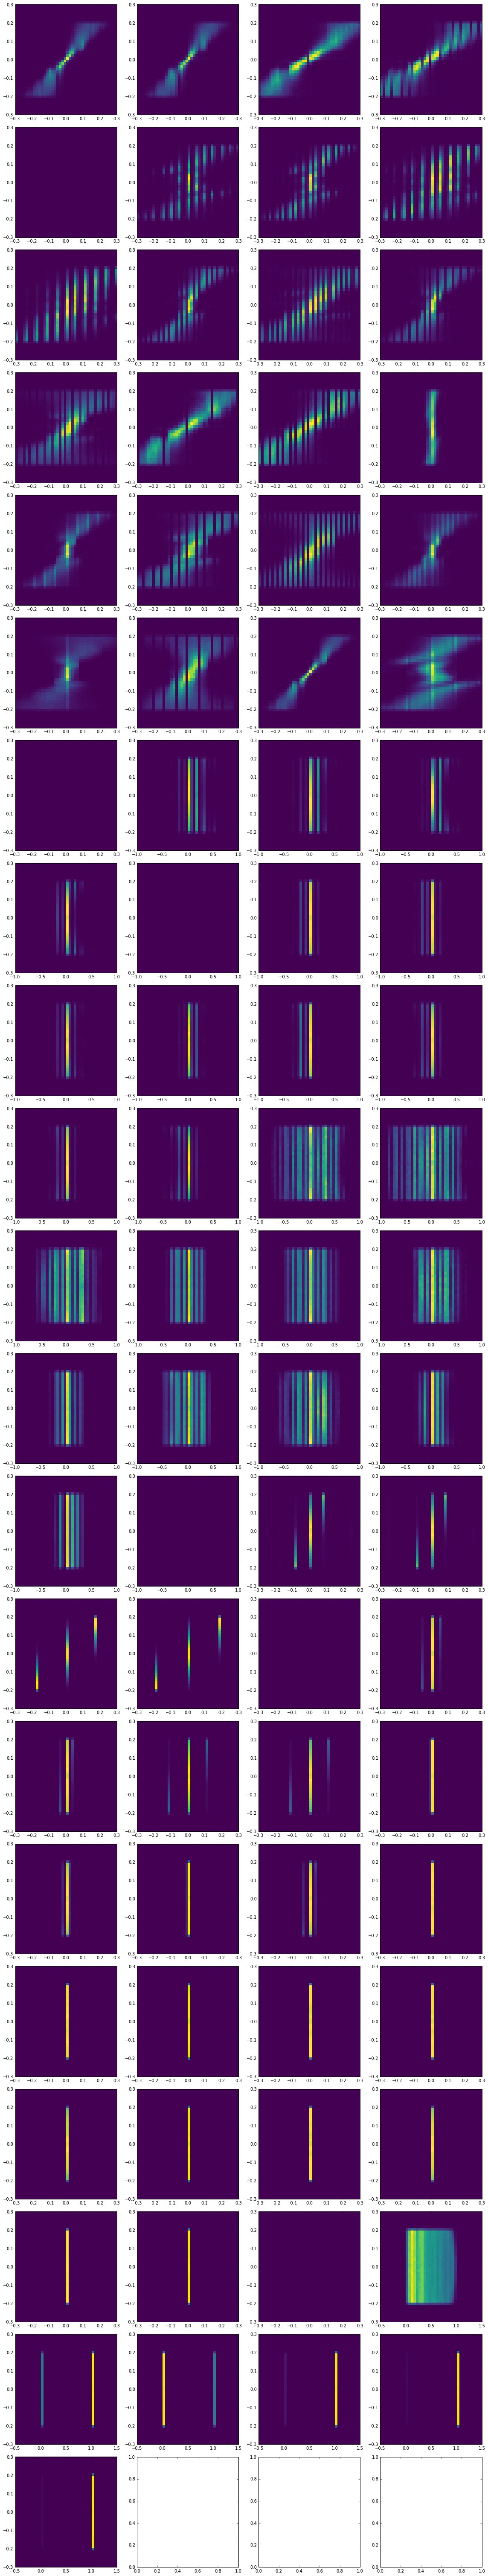

In [10]:
if True:
  print x_train.shape, y_train.shape, x_mask_train.shape

  fig, axs = plt.subplots(84/4, 4, figsize=(4*4,4*84/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    mask = x_mask_train[...,(i%25)]
    mask = mask.astype(np.bool)
    if i >= (nlayers*3):
      mask *= False

    #fig, ax = plt.subplots(tight_layout=True)
    xmin, xmax = -0.3, 0.3
    ymin, ymax = -0.3, 0.3
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -1, 1
    elif i == 75:
      xmin, xmax = -0.5, 1.5
    elif 76 <= i < 81:
      xmin, xmax = -0.5, 1.5
    
    hist = axs[(i/4, i%4)].hist2d(x_train[...,i][~mask], y_train[~mask], bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
    if x_train[...,i][~mask].size > 0:
      print i, np.mean(x_train[...,i][~mask]), np.std(x_train[...,i][~mask]), np.percentile(x_train[...,i][~mask], [2,98])

In [11]:
class MoreChiSquare(object):  # this guy handles data after scaled
  
  def __init__(self, x, x_mask, y):
    
    self.nentries = 40000 * 3 * 10
    self.nvariables = (nlayers * 3)
    #self.nvariables = (nlayers)
    
    self.x = x[:self.nentries, :self.nvariables]
    self.x_mask = x_mask[:self.nentries]
    self.y = y[:self.nentries]
    #assert(self.x.shape == self.x_mask.shape)
    assert(self.x.shape[0] == self.y.shape[0])
    
    theta_var = (nlayers * 3) + 0
    self.x_theta_median = x[:self.nentries, theta_var]
    
    self.theta_bins = (6, 0.0, 1.0)
    self.pt_bins = (40, -0.2, 0.2)
    self.chsq_offset = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_scale = np.ones((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_offset_1 = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_scale_1 = np.ones((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self._find_difference()

  def _find_bin(self, x, bins):
    x = np.clip(x, bins[1], bins[2]-1e-8)
    binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
    return int(binx)

  def _find_theta_bin(self, theta):
    return self._find_bin(theta, self.theta_bins)

  def _find_pt_bin(self, pt):
    return self._find_bin(pt, self.pt_bins)

  def _find_difference(self):
    for i in xrange(self.nvariables):
      print('[INFO] Find difference for var {0}'.format(i))

      lay = (i % nlayers)
      valid = ~self.x_mask[:,lay]
      x_i = self.x[:,i][valid]
      y_i = self.y[valid]
      #print x_i, y_i

      if x_i.size == 0:
        continue
      if x_i.size < 400:
        print('[WARNING] Not enough statistics: {0}'.format(x_i.size))
        
      theta_i = self.x_theta_median[valid]

      # Reuse the pattern technology
      patterns = [[[] for ipt in xrange(self.pt_bins[0])] for itheta in xrange(self.theta_bins[0])]
      
      for x, y, theta in zip(x_i, y_i, theta_i):
        y = np.clip(y, self.pt_bins[1], self.pt_bins[2])
        the_patterns = patterns[self._find_theta_bin(theta)][self._find_pt_bin(y)]
        the_patterns.append(x)

      for itheta in xrange(self.theta_bins[0]):
        for ipt in xrange(self.pt_bins[0]):
          if len(patterns[itheta][ipt]) == 0:
            continue
          if len(patterns[itheta][ipt]) < 40:
            #print('[WARNING] Not enough statistics: {0} {1} {2}'.format(itheta, ipt, len(patterns[itheta][ipt])))
            patterns[itheta][ipt] = []
            continue
          p = np.percentile(patterns[itheta][ipt], [25, 50, 75], overwrite_input=True)
          patterns[itheta][ipt] = p
      
      for itheta in xrange(self.theta_bins[0]):
        for ipt in xrange(self.pt_bins[0]):
          p = patterns[itheta][ipt]
          if len(p) == 0:
            p = [-0.5, 0, 0.5]
          assert(len(p) == 3)
          self.chsq_offset[itheta,ipt,i] = p[1]
          if p[2] > p[0]:
            self.chsq_scale[itheta,ipt,i] = 1.0 / (p[2] - p[0])
          else:
            self.chsq_scale[itheta,ipt,i] = 1.0
          #print itheta, ipt, i, p, self.chsq_offset[itheta,ipt,i], self.chsq_scale[itheta,ipt,i]
      
      smooth = True
      if smooth:
        from scipy.interpolate import Rbf
        x = [self.pt_bins[1] + (ipt+0.5)/self.pt_bins[0]*(self.pt_bins[2] - self.pt_bins[1]) for ipt in xrange(self.pt_bins[0])]
        for itheta in xrange(self.theta_bins[0]):
          assert(len(x) == len(self.chsq_offset[itheta,:,i]))
          rbf = Rbf(x, self.chsq_offset[itheta,:,i], smooth = 0.3, function='multiquadric')
          self.chsq_offset_1[itheta,:,i] = rbf(x)
          rbf = Rbf(x, self.chsq_scale[itheta,:,i], smooth = 0.3, function='multiquadric')
          self.chsq_scale_1[itheta,:,i] = rbf(x)

          
  def save_chsq(self, filepath):
    with np.load(chsqfile) as loaded:
      self.cov = loaded['cov']
      self.cov_1 = loaded['cov_1']
      self.cov_2 = loaded['cov_2']
      self.cov_3 = loaded['cov_3']
    np.savez_compressed(filepath, cov=self.cov, cov_1=self.cov_1, cov_2=self.cov_2, cov_3=self.cov_3, 
                        chsq_offset=self.chsq_offset, chsq_scale=self.chsq_scale, chsq_offset_1=self.chsq_offset_1, chsq_scale_1=self.chsq_scale_1)

  def load_chsq(self, filepath):
    loaded = np.load(filepath)
    self.cov = loaded['cov']
    self.cov_1 = loaded['cov_1']
    self.cov_2 = loaded['cov_2']
    self.cov_3 = loaded['cov_3']
    self.chsq_offset = loaded['chsq_offset']
    self.chsq_scale = loaded['chsq_scale']
    self.chsq_offset_1 = loaded['chsq_offset_1']
    self.chsq_scale_1 = loaded['chsq_scale_1']
    

In [12]:
chsq = MoreChiSquare(x_train, x_mask_train, y_train)
chsq.save_chsq('chsq.npz')
print('[INFO] MoreChiSquare is saved as chsq.npz')

[INFO] Find difference for var 0
[INFO] Find difference for var 1
[INFO] Find difference for var 2
[INFO] Find difference for var 3
[INFO] Find difference for var 4
[INFO] Find difference for var 5
[INFO] Find difference for var 6
[INFO] Find difference for var 7
[INFO] Find difference for var 8
[INFO] Find difference for var 9
[INFO] Find difference for var 10
[INFO] Find difference for var 11
[INFO] Find difference for var 12
[INFO] Find difference for var 13
[INFO] Find difference for var 14
[INFO] Find difference for var 15
[INFO] Find difference for var 16
[INFO] Find difference for var 17
[INFO] Find difference for var 18
[INFO] Find difference for var 19
[INFO] Find difference for var 20
[INFO] Find difference for var 21
[INFO] Find difference for var 22
[INFO] Find difference for var 23
[INFO] Find difference for var 24
[INFO] Find difference for var 25
[INFO] Find difference for var 26
[INFO] Find difference for var 27
[INFO] Find difference for var 28
[INFO] Find difference f

In [13]:
print chsq.chsq_offset
print chsq.chsq_scale
print chsq.chsq_offset_1
print chsq.chsq_scale_1

[[[-0.10790531 -0.10962638  0.         ...,  0.          0.          0.        ]
  [-0.10345561 -0.10434318  0.         ...,  0.          0.          0.        ]
  [-0.09900591 -0.09707878  0.         ...,  0.          0.          0.        ]
  ..., 
  [ 0.0901065   0.08981438  0.         ...,  0.          0.          0.        ]
  [ 0.0945562   0.09509758  0.         ...,  0.          0.          0.        ]
  [ 0.10011833  0.10038078  0.         ...,  0.          0.          0.        ]]

 [[-0.14684023 -0.14660877  0.         ...,  0.          0.          0.        ]
  [-0.13905324 -0.14000477  0.         ...,  0.          0.          0.        ]
  [-0.13682839 -0.13604237  0.         ...,  0.          0.          0.        ]
  ..., 
  [ 0.12792899  0.12679677  0.         ...,  0.          0.          0.        ]
  [ 0.13349111  0.13340077  0.         ...,  0.          0.          0.        ]
  [ 0.14016567  0.13868397  0.         ...,  0.          0.          0.        ]]

 [[-0.18

In [14]:
print np.where(chsq.chsq_scale<=0)
print np.where(chsq.chsq_scale_1<=0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [15]:
#### Application ####

import ROOT

ROOT.gROOT.LoadMacro("tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")
ROOT.gStyle.SetPalette(57)  # kBird
ROOT.gStyle.SetPadGridX(True)
ROOT.gStyle.SetPadGridY(True)

h1a = ROOT.TEfficiency("effa", "effa", 50, 0, 100)
h1b = ROOT.TEfficiency("effb", "effb", 50, 0, 100)
h2a = ROOT.TH2F("h2a", "h2a", 12, 0, 12, 100, 0, 100)
h2b = ROOT.TH2F("h2b", "h2b", 12, 0, 12, 100, 0, 100)
n2a = []
n2b = []
n2a_1 = []
n2b_1 = []


def simple_chisquare(x, x_mask, y, theta):  
  def _calc(ivar):
    if ~x_mask[ivar]:
      x_meas = x[ivar]
      assert(np.isfinite(x_meas))
      x_meas -= chsq.chsq_offset_1[itheta,ipt,ivar]
      x_meas *= chsq.chsq_scale_1[itheta,ipt,ivar]
      return abs(x_meas)
    else:
      return -1

  itheta = chsq._find_theta_bin(theta)
  ipt = chsq._find_pt_bin(y)
  
  if theta >= 0.566265:  # zones 0,1
    angle1 = _calc(2)  # ME1/2f
    if angle1 == -1:
      angle1 = _calc(3)  # ME1/2r
    angle2 = _calc(10)  # ME3/2
    if angle2 == -1:
      angle2 = _calc(12)  # ME4/2
  elif theta >= 0.144578:  # zones 2,3,4,5
    angle1 = _calc(22)  # GE1/1
    angle2 = _calc(0)  # ME1/1f
    if angle2 == -1:
      angle2 = _calc(1)  # ME1/1r
  elif theta >= 0.0:  # zones 6
    angle1 = _calc(23)  # GE2/1
    angle2 = _calc(0)  # ME1/1f
    if angle2 == -1:
      angle2 = _calc(1)  # ME1/1r
  else:
    assert(False)
  return (angle1, angle2)
  

def simple_trigger(ndof, chi2):
  assert(np.isfinite(chi2))
  if 0 <= ndof < 5:
    return chi2 < 15.
  elif ndof < 7:
    return chi2 < 25.
  elif ndof < 9:
    return chi2 < 30.
  else:
    return chi2 < 80.



nvariables_to_scale = chsq.nvariables
nentries_test = 100000 * 2
x_copy = x_train[:nentries_test, :nvariables_to_scale].copy()
y_copy = y_train[:nentries_test].copy()

theta_var = (nlayers * 3) + 0
theta_copy = x_train[:nentries_test, theta_var].copy()

x_mask_copy = x_mask_train[:nentries_test].copy()


# Loop over events
for i in xrange(nentries_test):
  x = x_copy[i].copy()
  y = y_copy[i]
  theta = theta_copy[i]
  x_mask = x_mask_copy[i]
  
  #print x, y, theta, x_mask
  
  if np.abs(y) > 1.0/14:  # ignore less than 14 GeV tracks
    continue
  
  itheta = chsq._find_theta_bin(theta)
  ipt = chsq._find_pt_bin(y)
  offset = chsq.chsq_offset_1[itheta,ipt]
  scale = chsq.chsq_scale_1[itheta,ipt]
  
  valid = ~x_mask
  x -= offset
  x *= scale
  x = x[np.tile(valid,3)]
  x **= 2
  chi2 = x.sum()
  ndof = valid.sum()
  
  h2a.Fill(ndof, chi2)
  n2a.append((ndof, chi2))
  
  trigger = simple_trigger(ndof, chi2)
  h1a.Fill(trigger, np.abs(1.0/y))
  
  x = x_copy[i].copy()
  angle1, angle2 = simple_chisquare(x, x_mask, y, theta)
  n2a_1.append((ndof, angle1, angle2))
  
  if i < 20:
    print i, ndof, chi2, theta, angle1, angle2


Welcome to JupyROOT 6.10/05
2 6 10.8791 0.855422 1.09127 0.943358
3 6 6.49129 0.572289 -1 0.890238
5 6 3.07535 0.108434 0.0427933 0.469233
6 6 4.29541 0.409639 0.889461 0.871642
9 7 4.11479 0.108434 0.916725 1.16498
11 6 1.52022 0.277108 0.125369 0.347352
14 8 8.5254 0.253012 0.838466 0.676627
15 8 9.63546 0.313253 0.100822 0.0113671
16 5 2.39732 0.204819 -1 0.16237


In [16]:
# minbias events
with np.load('histos_tbb_add.npz') as data:
  minbias_variables = data['variables']
  minbias_predictions = data['predictions']  
  print minbias_variables.shape, minbias_predictions.shape
  
  tmp_1 = np.zeros(minbias_predictions.shape, dtype=np.float32) + 0
  tmp_2 = np.zeros(minbias_predictions.shape, dtype=np.float32) + 1.8
  minbias_predictions = np.hstack((minbias_predictions, tmp_1, tmp_2))
  
encoder = Encoder(minbias_variables, minbias_predictions, adjust_scale=2)
minbias_x, minbias_y, minbias_w, minbias_x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()


nvariables_to_scale = chsq.nvariables
nentries_test = minbias_variables.shape[0]
x_copy = minbias_x[:nentries_test, :nvariables_to_scale].copy()
y_copy = minbias_y[:nentries_test].copy()

theta_var = (nlayers * 3) + 0
theta_copy = minbias_x[:nentries_test, theta_var].copy()

x_mask_copy = minbias_x_mask[:nentries_test].copy()

for i in xrange(nentries_test):
  x = x_copy[i].copy()
  y = y_copy[i]
  theta = theta_copy[i]
  x_mask = x_mask_copy[i]
  
  #print x, y, theta, x_mask
  
  if np.abs(y) > 1.0/14:  # ignore less than 14 GeV tracks
    continue
  
  itheta = chsq._find_theta_bin(theta)
  ipt = chsq._find_pt_bin(y)
  offset = chsq.chsq_offset_1[itheta,ipt]
  scale = chsq.chsq_scale_1[itheta,ipt]
  
  valid = ~x_mask
  x -= offset
  x *= scale
  x = x[np.tile(valid,3)]
  x **= 2
  chi2 = x.sum()
  ndof = valid.sum()
  
  h2b.Fill(ndof, chi2)
  n2b.append((ndof, chi2))
  
  trigger = simple_trigger(ndof, chi2)
  h1b.Fill(trigger, np.abs(1.0/y))
  
  x = x_copy[i].copy()
  angle1, angle2 = simple_chisquare(x, x_mask, y, theta)
  n2b_1.append((ndof, angle1, angle2))
  
  if i < 20:
    print i, ndof, chi2, theta, angle1, angle2
  

(68402, 104) (68402, 1)


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater


4 5 223.332 0.60241 8.6729 6.89472
11 5 89.3196 0.289157 -1 5.04121


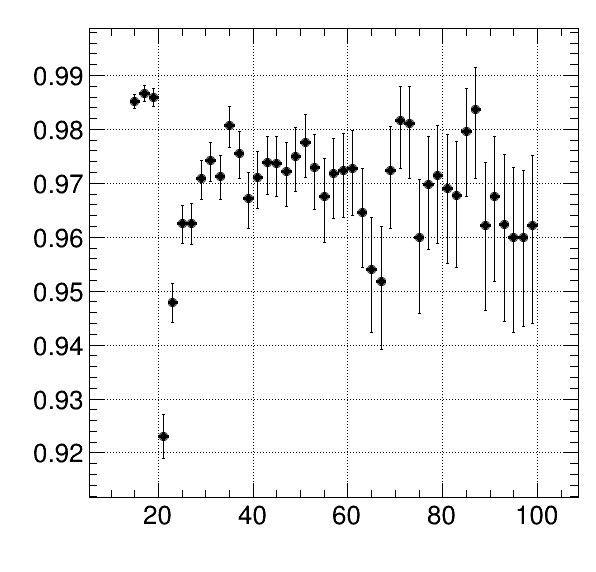

In [17]:
c = ROOT.TCanvas()
h1a.Draw("ap")
c.Draw()

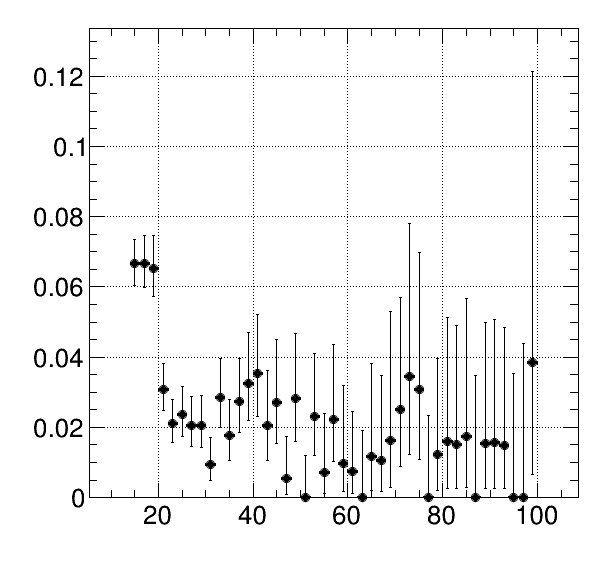

In [18]:
c = ROOT.TCanvas()
h1b.Draw("ap")
c.Draw()

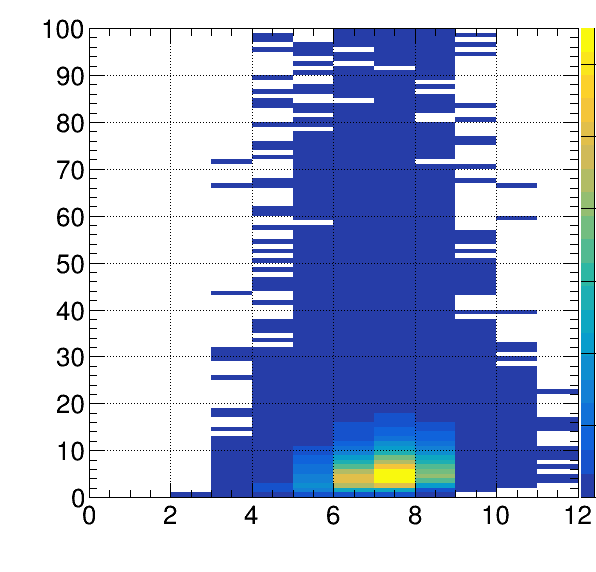

In [19]:
c = ROOT.TCanvas()
h2a.Draw("COLZ")
c.Draw()

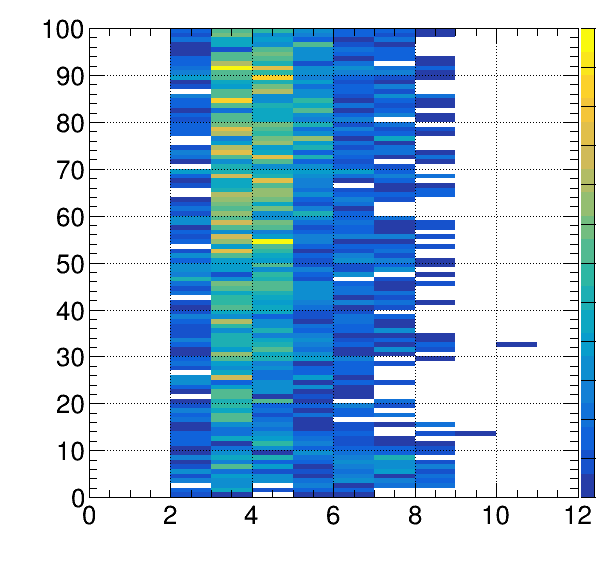

In [20]:
c = ROOT.TCanvas()
h2b.Draw("COLZ")
c.Draw()

(71392, 2) (13584, 2)
0 0 0
1 0 0
2 1 592
3 147 3797
4 1258 3925
5 6227 2396
6 19136 1386
7 27479 1065
8 15756 401
9 1137 16
10 231 5
11 20 1
12 0 0
0 [  12.16700416   17.07070446   20.88651237   35.03880978  138.73588257
  261.62528     366.16113586]
0 1406 8314
1 [  11.53395544   13.45041351   15.33644867   21.28273315   46.310961
   96.59787094  179.31952896]
1 25363 3782
2 [  12.64489185   14.27491646   16.00823669   20.82284927   41.06553146
   79.26363907  133.72575363]
2 43235 1466
3 [ 17.49630568  19.88024864  21.50834206  26.47793217  45.72258186
  67.67395523  96.43061634]
3 1388 22


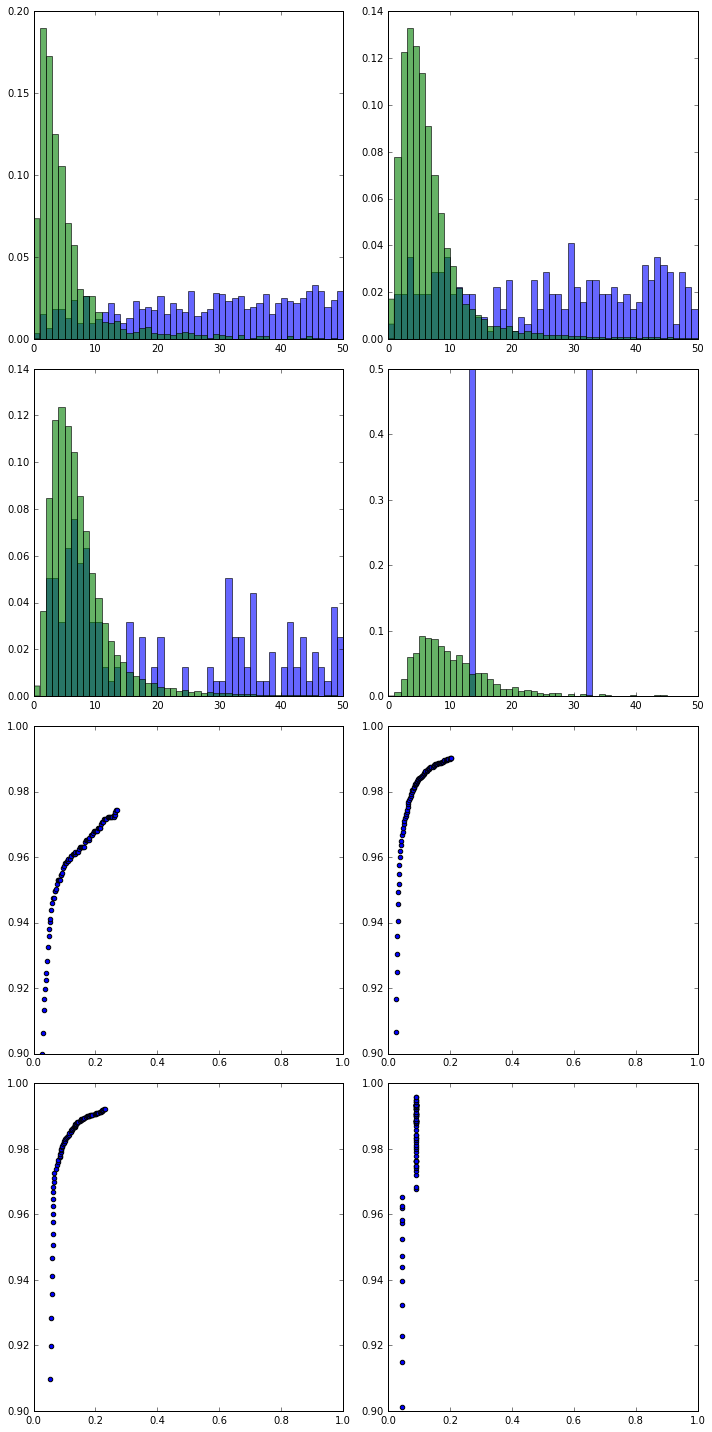

In [21]:
n2a = np.asarray(n2a)
n2b = np.asarray(n2b)

print n2a.shape, n2b.shape
for i in xrange(13):
  print i, len(n2a[n2a[:,0] == i]), len(n2b[n2b[:,0] == i])

  
fig, axs = plt.subplots(4, 2, figsize=(5*2,5*4), tight_layout=True)

for i in xrange(4):
  if i == 0:
    ind_a = (0 <= n2a[:,0]) & (n2a[:,0] < 5)
    ind_b = (0 <= n2b[:,0]) & (n2b[:,0] < 5)
  elif i == 1:
    ind_a = (5 <= n2a[:,0]) & (n2a[:,0] < 7)
    ind_b = (5 <= n2b[:,0]) & (n2b[:,0] < 7)
  elif i == 2:
    ind_a = (7 <= n2a[:,0]) & (n2a[:,0] < 9)
    ind_b = (7 <= n2b[:,0]) & (n2b[:,0] < 9)
  elif i == 3:
    ind_a = (9 <= n2a[:,0]) & (n2a[:,0] < 15)
    ind_b = (9 <= n2b[:,0]) & (n2b[:,0] < 15)

  xmin, xmax = 0., 50.
  hist = axs[(i/2, i%2)].hist(n2b[ind_b,1], bins=50, range=[xmin, xmax], alpha=0.6, normed=True)
  hist = axs[(i/2, i%2)].hist(n2a[ind_a,1], bins=50, range=[xmin, xmax], alpha=0.6, normed=True)
  
  print i, np.percentile(n2a[ind_a,1], [87, 90, 92, 95, 98, 99, 99.5], overwrite_input=True)
  
  # ROC
  sig = np.sort(n2a[ind_a,1])
  bkg = np.sort(n2b[ind_b,1])
  nsig = len(sig)
  nbkg = len(bkg)
  print i, nsig, nbkg
  
  sig_cut = sig[:,np.newaxis] < np.linspace(1,100,100)
  bkg_cut = bkg[:,np.newaxis] < np.linspace(1,100,100)
  #print sig_cut.shape, bkg_cut.shape
  
  sig_eff = np.sum(sig_cut, axis=0)
  bkg_eff = np.sum(bkg_cut, axis=0)
  #print sig_eff.shape, bkg_eff.shape
  
  sig_eff = np.true_divide(sig_eff, nsig)
  bkg_eff = np.true_divide(bkg_eff, nbkg)
  #print sig_eff
  #print bkg_eff
  
  j = i + 4
  scat = axs[(j/2, j%2)].scatter(bkg_eff, sig_eff)
  axs[(j/2, j%2)].set_xlim(0, 1)
  axs[(j/2, j%2)].set_ylim(0.9, 1)


(71392, 3) (13584, 3)
0 0 0
1 0 0
2 1 592
3 147 3797
4 1258 3925
5 6227 2396
6 19136 1386
7 27479 1065
8 15756 401
9 1137 16
10 231 5
11 20 1
12 0 0
0 [  12.16700416   17.07070446   20.88651237   35.03880978  138.73588257
  261.62528     366.16113586]
0 1406 8314
1 [  11.53395544   13.45041351   15.33644867   21.28273315   46.310961
   96.59787094  179.31952896]
1 25363 3782
2 [  12.64489185   14.27491646   16.00823669   20.82284927   41.06553146
   79.26363907  133.72575363]
2 43235 1466
3 [ 17.49630568  19.88024864  21.50834206  26.47793217  45.72258186
  67.67395523  96.43061634]
3 1388 22


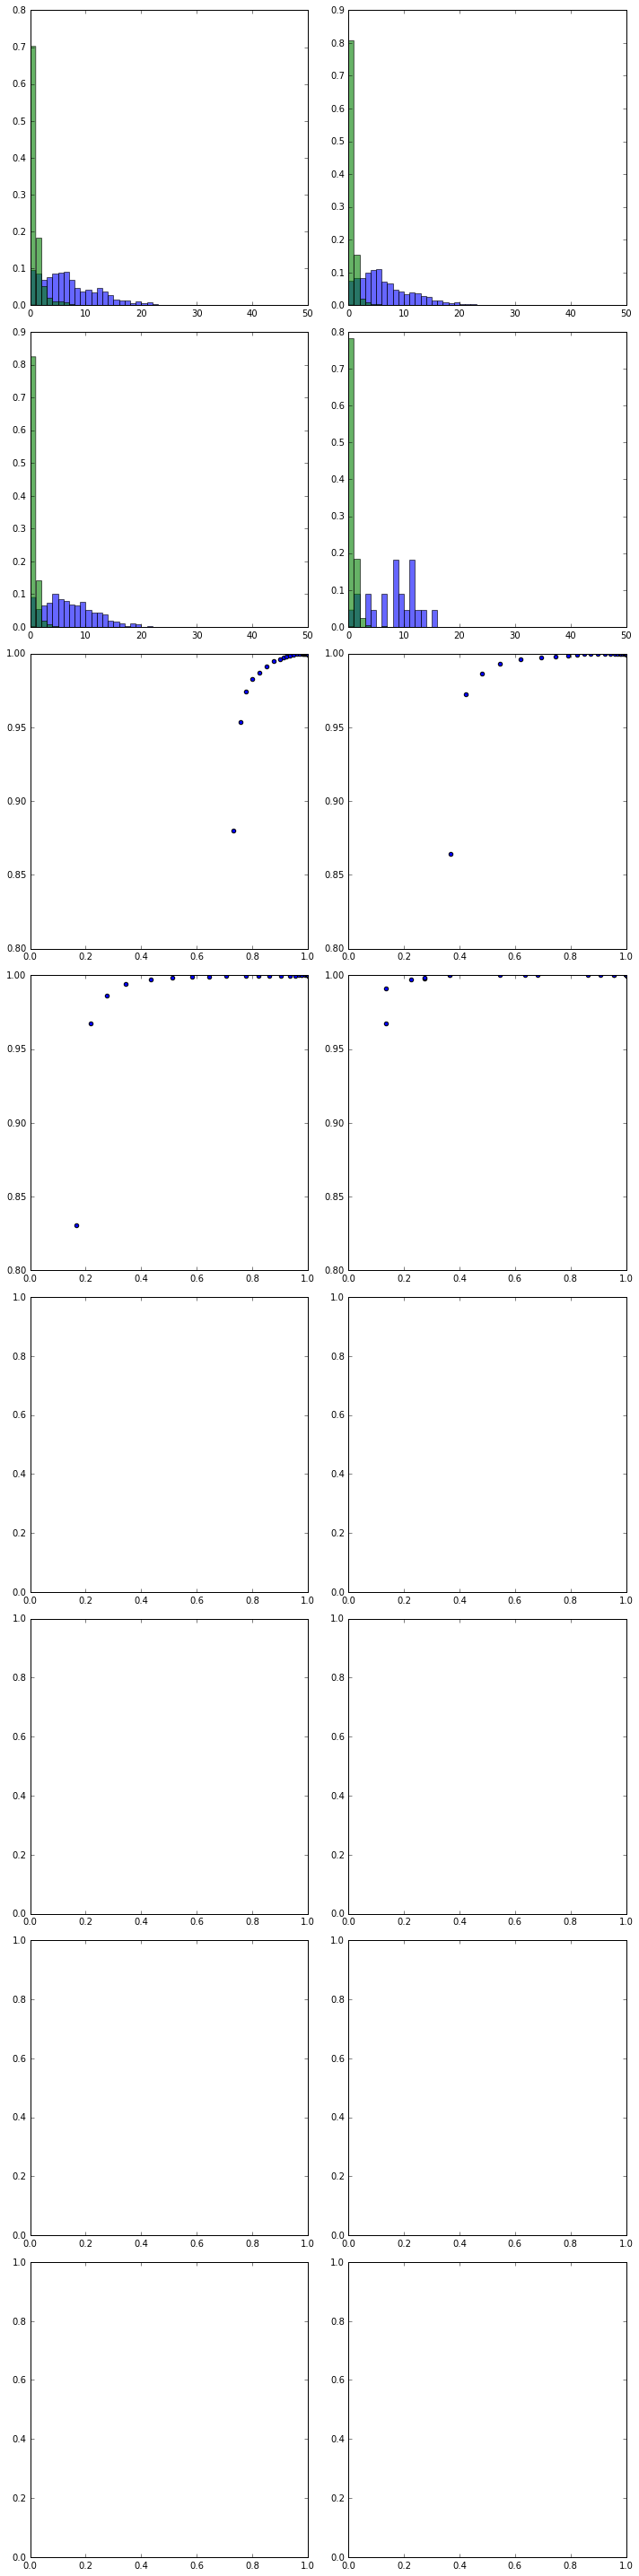

In [22]:
n2a_1 = np.asarray(n2a_1)
n2b_1 = np.asarray(n2b_1)

print n2a_1.shape, n2b_1.shape
for i in xrange(13):
  print i, len(n2a_1[n2a_1[:,0] == i]), len(n2b_1[n2b_1[:,0] == i])

  
fig, axs = plt.subplots(8, 2, figsize=(5*2,5*8), tight_layout=True)

for i in xrange(4):
  if i == 0:
    ind_a = (0 <= n2a_1[:,0]) & (n2a_1[:,0] < 5)
    ind_b = (0 <= n2b_1[:,0]) & (n2b_1[:,0] < 5)
  elif i == 1:
    ind_a = (5 <= n2a_1[:,0]) & (n2a_1[:,0] < 7)
    ind_b = (5 <= n2b_1[:,0]) & (n2b_1[:,0] < 7)
  elif i == 2:
    ind_a = (7 <= n2a_1[:,0]) & (n2a_1[:,0] < 9)
    ind_b = (7 <= n2b_1[:,0]) & (n2b_1[:,0] < 9)
  elif i == 3:
    ind_a = (9 <= n2a_1[:,0]) & (n2a_1[:,0] < 15)
    ind_b = (9 <= n2b_1[:,0]) & (n2b_1[:,0] < 15)

  xmin, xmax = 0., 50.
  ymin, ymax = 0., 50.
  hist = axs[(i/2, i%2)].hist(n2b_1[ind_b,1], bins=50, range=[xmin, xmax], alpha=0.6, normed=True)
  hist = axs[(i/2, i%2)].hist(n2a_1[ind_a,1], bins=50, range=[xmin, xmax], alpha=0.6, normed=True)
  
  print i, np.percentile(n2a[ind_a,1], [87, 90, 92, 95, 98, 99, 99.5], overwrite_input=True)
  
  
  # ROC
  sig = np.sort(n2a_1[ind_a,1])
  bkg = np.sort(n2b_1[ind_b,1])
  nsig = len(sig)
  nbkg = len(bkg)
  print i, nsig, nbkg
  
  sig_cut = sig[:,np.newaxis] < np.linspace(1,100,100)
  bkg_cut = bkg[:,np.newaxis] < np.linspace(1,100,100)
  #print sig_cut.shape, bkg_cut.shape
  
  sig_eff = np.sum(sig_cut, axis=0)
  bkg_eff = np.sum(bkg_cut, axis=0)
  #print sig_eff.shape, bkg_eff.shape
  
  sig_eff = np.true_divide(sig_eff, nsig)
  bkg_eff = np.true_divide(bkg_eff, nbkg)
  #print sig_eff
  #print bkg_eff
  
  j = i + 4
  scat = axs[(j/2, j%2)].scatter(bkg_eff, sig_eff)
  axs[(j/2, j%2)].set_xlim(0, 1)
  axs[(j/2, j%2)].set_ylim(0.8, 1)

[INFO] Start training.
[INFO] Done training.


(0.0, 100.0)

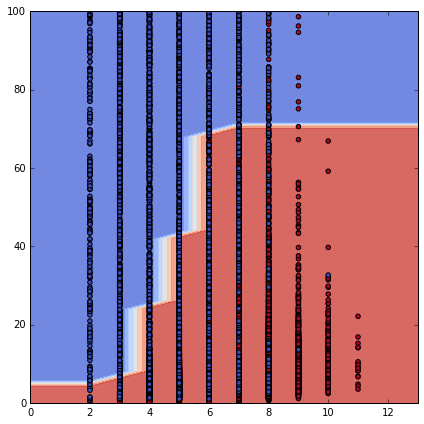

In [23]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


X = np.vstack((n2a, n2b))
y_a = np.ones((n2a.shape[0],1), dtype=np.float32)
y_b = np.zeros((n2b.shape[0],1), dtype=np.float32)
y = np.vstack((y_a, y_b))[:,0]

#X = np.vstack((n2a[:10000], n2b[:10000]))
#y_a = np.ones((n2a.shape[0],1), dtype=np.float32)
#y_b = np.zeros((n2b.shape[0],1), dtype=np.float32)
#y = np.vstack((y_a[:10000], y_b[:10000]))[:,0]

print('[INFO] Start training.')
#clf = SVC(kernel='linear', C=0.5)
#clf = SVC(kernel='rbf', gamma=0.7, C=1.0)
#clf = SVC(kernel='poly', degree=3, C=1.0)
clf = RandomForestClassifier(max_depth=3, n_estimators=50, max_features=1)
clf = clf.fit(X,y)
print('[INFO] Done training.')

fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

X0, X1 = X[:, 0], X[:, 1]
xx, yy = np.meshgrid(np.linspace(0,13,14), np.linspace(0,100,51))

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())


In [ ]:
########################## PLEASE IGNORE

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.covariance import EmpiricalCovariance, MinCovDet


class ChiSquare(object):
  
  def __init__(self, x, x_mask, x_ieta, y):
    
    self.nentries = 40000
    self.nvariables = 75
    self.nzones = 6
    
    self.x = x[:self.nentries, :self.nvariables]
    self.x_mask = x_mask[:self.nentries]
    self.x_mask = np.tile(self.x_mask, 3)
    self.y = y[:self.nentries]
    self.x_ieta = x_ieta[:self.nentries]
    assert self.x.shape == self.x_mask.shape
    assert self.x.shape[0] == self.x_ieta.shape[0]
    assert self.x.shape[0] == self.y.shape[0]
    
    self.cov = np.zeros((self.nzones,self.nvariables), dtype=np.float32)
    self._find_covariance()
    
    self.offset = np.zeros((self.nzones,self.nvariables), dtype=np.float32)
    self.scale = np.zeros((self.nzones,self.nvariables), dtype=np.float32)
    self._find_difference()
    
    
  def _find_covariance(self):
    
    for zone in xrange(self.nzones):
      for i in xrange(self.nvariables):
        if i >= 25:
          continue
        
        print('[INFO] Find covariance on zone {0} var {1}'.format(zone, i))
                
        valid = (self.x_ieta == zone) & (~self.x_mask[:,i])
        x_i = self.x[:,i][valid]
        y_i = self.y[valid]
        #print x_i, y_i
        
        if x_i.size == 0:
          continue

        x_mean = np.mean(x_i)
        x_i -= x_mean
        
        x_std = np.std(x_i)
        if x_std == 0:
          continue

        # http://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html
        # Minimum Covariance Determinant (MCD): robust estimator of covariance.
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]
        self.cov[zone, i] = 1.0 / coef  # do the inverse
        print coef, mcd.covariance_
        
        # Check with simple linear regression y = a * x
        lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        print lr.intercept_, lr.coef_
        

  def _find_difference(self):
    
    for zone in xrange(self.nzones):
      for i in xrange(self.nvariables):
        
        print('[INFO] Find difference on zone {0} var {1}'.format(zone, i))
        
        valid = (self.x_ieta == zone) & (~self.x_mask[:,i])
        x_i = self.x[:,i][valid]
        y_i = self.y[valid]
        
        if x_i.size == 0:
          continue
        
        coef = self.cov[zone, i]
        x_pred = y_i * coef  # use the inverse
        x_diff = x_i - x_pred
        
        quantile_range = (25.0, 50.0, 75.0)
        q = np.percentile(x_diff, quantile_range)
        self.offset[zone, i] = q[1]
        if q[2] > q[0]:
          self.scale[zone, i] = 1.0 / (q[2] - q[0])  # do the inverse
        else:
          self.scale[zone, i] = 1.0
        print q
        print np.mean(x_diff), np.std(x_diff)
        
        
  def save_chsq(self, filepath):
    np.savez_compressed(filepath, cov=self.cov, offset=self.offset, scale=self.scale)

  def load_chsq(self, filepath):
    loaded = np.load(filepath)
    self.cov = loaded['cov']
    self.offset = loaded['offset']
    self.scale = loaded['scale']


In [ ]:
chsq = ChiSquare(x_train, x_mask_train, x_ieta_train, y_train)
chsq.save_chsq('chsq.npz')
print('[INFO] ChiSquare is saved as chsq.npz')

In [ ]:
yy = []
zz = []

for x, x_mask, zone, y in zip(x_train, x_mask_train, x_ieta_train, y_train[:1000]):
  
  x = x[:chsq.nvariables]
  x_mask = np.tile(x_mask, 3)
  valid = ~x_mask
  
  coef = chsq.cov[zone]
  offset = chsq.offset[zone]
  scale = chsq.scale[zone]
  
  x_pred = y * coef
  #print x, x_pred
  
  x_diff = (x_pred - x - offset) 
  x_diff *= scale  # use the inverse
  x_diff **= 2
  
  x_diff = x_diff[valid]
  #x_diff = np.sort(x_diff)[::-1]  # sort descending
  x_diff[::-1].sort()  # sort descending in-place
  x_diff = x_diff[:3]
  
  z = x_diff.sum()
  yy.append(y)
  zz.append(z)
  
  

In [ ]:
_ = plt.hist(zz, bins=40, range=[0,50])

In [ ]:
_ = plt.hist2d(zz, yy, bins=40, range=[[0,50],[-0.2,0.2]])